In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FACE DETECTION

In [2]:
def bounding_box_area(bounding_box):
    return bounding_box[2] * bounding_box[3]

In [126]:
#violajones face detection using opencv
def detect_faces(image_path, scaleFactor=1.4, minNeighbors = 4, minSize = (10,10)):
    #read image
    image = cv2.imread(image_path)
    #load the pre-trained model
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    #convert the image to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #detect faces
    faces = face_cascade.detectMultiScale(
        gray_image,
        scaleFactor=scaleFactor,
        minNeighbors=minNeighbors,
        minSize=minSize,
    )

    HEIGHT = image.shape[0]
    WIDTH = image.shape[1]

    #if no bounding boxes are found, take most of the image
    if len(faces) == 0:
        bbox = np.array([0.2*WIDTH,0.1*HEIGHT,0.6*WIDTH,0.8*HEIGHT]).astype(int)
        return bbox
    
    #if more bounding boxes are found take the largest one 
    max_area_face = faces[0]
    for face in faces:
        if bounding_box_area(face) > bounding_box_area(max_area_face):
            max_area_face = face
    #return the bounding boxes
    return max_area_face


In [4]:
def compute_iou(box1, box2):
    # determine the (x, y)-coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])

    # compute the area of intersection rectangle
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    #compute the area of both the prediction and ground-truth boxes
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    # compute the union area
    union_area = box1_area + box2_area - inter_area
    #return IoU
    return inter_area / union_area if union_area > 0 else 0


In [5]:
def evaluate_model(dataset, scaleFactor, minNeighbors, minSize):
    #iou scores for each sample
    iou_scores = []
    for item in dataset["identity"].unique():
        #get all the samples for a particular identity
        df = dataset[dataset["identity"] == item]
        
        #for each sample of the same identity
        for i in range(len(df)):            
            path = "data/" + str(df.iloc[i]["idx"]) + ".jpg"
            # Ground truth (CNNs) bounding boxes
            gt_box = [df.iloc[i]["x_1"], df.iloc[i]["y_1"], df.iloc[i]["width"], df.iloc[i]["height"]] 
            
            # Detected bounding boxes with viola-jones
            detected_face = detect_faces(path, scaleFactor, minNeighbors, minSize)
            
            #compute iou
            iou = compute_iou(gt_box, detected_face)
            
                
        iou_scores.append(iou)

    avg_iou = np.mean(iou_scores) if iou_scores else 0
    return avg_iou

In [223]:
def optimize_parameters(dataset):
    best_params = {}
    best_iou = 0
    #grid search for best parameters
    for scaleFactor in [1.4]:
        for minNeighbors in [4]:
            for minSize in [(500,500)]:
                avg_iou = evaluate_model(dataset, scaleFactor, minNeighbors, minSize)
                print(f"minNei{minNeighbors}, minSize{minSize}, scale{scaleFactor},iou{avg_iou}")
                if avg_iou > best_iou:
                    best_iou = avg_iou
                    #dict of best parameters
                    best_params = {
                        "scaleFactor": scaleFactor,
                        "minNeighbors": minNeighbors,
                        "minSize": minSize,
                    }
    return best_params, best_iou

In [7]:
def test_model(dataset, best_params):
    #test the model with the optimized parameters, calc avg iou
    avg_iou = evaluate_model(
        dataset,
        best_params["scaleFactor"],
        best_params["minNeighbors"],
        best_params["minSize"],
    )
    print(f"Average IoU on test set: {avg_iou}")

In [224]:
# Load the dataset
df = pd.read_csv('CelebA-HQ-small.csv')
# Get the train split
df_train = df.loc[df["split"] == "train"]
# train the model
best_params, best_iou =  optimize_parameters(df_train)


minNei4, minSize(500, 500), scale1.4,iou0.7028187684638405


In [13]:
print(f"Best parameters: {best_params}")
print(f"Best IoU on train set: {best_iou}")

Best parameters: {'scaleFactor': 1.4, 'minNeighbors': 4, 'minSize': (10, 10)}
Best IoU on train set: 0.7028187684638405


In [227]:
best_params = {'scaleFactor': 1.4, 'minNeighbors': 4, 'minSize': (1000, 1000)}

In [228]:
# Get the test split
df_test = df.loc[df["split"] == "test"]
# test the model
test_model(best_params=best_params, dataset=df_test)

Average IoU on test set: 0.7090209830543246


In [198]:
# Get the test split
df_test = df.loc[df["split"] == "test"]
# test the model
test_model(best_params=best_params, dataset=df_test)

Average IoU on test set: 0.6891934338268909


FEATURE EXTRACTION

In [94]:
def chi2_distance_similarity(A, B):
    try:
        chi = 0.5 * np.sum([((a - b) ** 2) / (a + b + 1e-5) for (a, b) in zip(A, B)])
    except:
        print(A)
        print(B)    
    
    return chi


LBP

In [9]:
from skimage.feature import local_binary_pattern


In [10]:
def extract_features_lbp(image, n_points=24, radius=3 ,grid_size=(4,4)):

    lbp = local_binary_pattern(image, n_points, radius, method="uniform")   

    features = []
    bins = n_points + 2

    height, width = lbp.shape

    for wx in range(0,width,grid_size[0]):
        for wy in range(0,height,grid_size[1]):
            hist = np.zeros(bins)
            for x in range(wx, min(wx + grid_size[0], width)):
                for y in range(wy, min(wy + grid_size[1], height)):
                    hist[int(lbp[y, x])] += 1
            features.extend(hist)
            
    return np.array(features)
    

In [11]:
def extract_lbp_features(image, radius=3, n_points=24, method='uniform', grid_size=(4, 4)):
    h, w = image.shape
    cell_h, cell_w = h // grid_size[0], w // grid_size[1]
    lbp_features = []

    # Compute LBP for the whole image
    lbp = local_binary_pattern(image, n_points, radius, method)

    # Loop through each grid cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Extract the cell region from the LBP image
            cell = lbp[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]

            # Compute the histogram for the cell
            lbp_hist, _ = np.histogram(cell.ravel(),
                                       bins=np.arange(0, n_points + 3),
                                       range=(0, n_points + 2))

            #normalize the histogram
            lbp_hist = lbp_hist.astype('float')
            lbp_hist /= (lbp_hist.sum() + 1e-6)

            # Append to the features list
            lbp_features.extend(lbp_hist)

    return np.array(lbp_features)


In [75]:
def preprocess_image(image_path,bounding_box, target_size=(128, 128),useBoundingBox=True):

    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or unable to read.")
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
        
    if useBoundingBox:
        x1 =  bounding_box[0]
        y1 = bounding_box[1]
        width = bounding_box[2]
        height = bounding_box[3]
        gray_image = gray_image[x1:x1+width, y1:y1+height]
    

    # Resize the image
    gray_image = cv2.resize(gray_image, target_size)
    
    return gray_image

In [44]:
def extract_all_feature_vectors_lbp(dataset, n_points=8, radius=1, grid_size=(4,4), useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)
        feature_vectors.append(extract_lbp_features(image, radius=radius, n_points=n_points, grid_size=grid_size))#, radius=radius, n_points=n_points, grid_size=grid_size))
        
    return np.array(feature_vectors), image_ids



In [61]:
def euclidean_distance(features1,features2):
    return np.linalg.norm(features1 - features2)

In [60]:
def get_scores_mtx(image_mtx,image_ids, method="chi"):
    df = pd.DataFrame(np.zeros(len(image_mtx)),columns=["identity"])
    dict_of_new_cols  ={}
    for i in range(len(image_mtx)):
        tmp = []
        
        row_tst = image_mtx[i]
        for j in range(len(image_mtx)):
            row_train = image_mtx[j]
            if i == j:
                tmp.append(np.inf)
            elif method == "chi":
                tmp.append(chi2_distance_similarity(row_tst, row_train))
            elif method == "euc":
                tmp.append(euclidean_distance(row_tst, row_train))
                
            if i == 0:
                df.iloc[j] = {"identity":int(image_ids[j])}
        dict_of_new_cols[str(i)] = tmp
        #df[str(i)] = tmp


    df_tmp = pd.DataFrame(dict_of_new_cols)
    df = pd.concat([df,df_tmp],axis=1)
    #take min, also possible mean        
        
    df_grp = df.groupby("identity").min()
    df_grp = df_grp.reset_index()

    return df_grp


In [155]:
def get_cmc(df_scores, image_ids):
    cmc = []
    for rank in range(1,len(df_scores+1)):
        prob = 0
        for i, col in enumerate(df_scores.drop("identity", axis=1).columns):
            id = df_scores.nsmallest(rank, col)["identity"].values.astype(int)
            corr_id = image_ids[i]

            if corr_id in id:
                prob += 1 
        prob /= len(image_ids)
        if rank == 1:
            rank1 = prob

        if rank == 5:
            rank5 = prob
        cmc.append(prob)
    return cmc, rank1, rank5


In [ ]:
#findig best params, by plotting cmc and printing ra1,r5
def optimize_lbp(train_dataset, bbox = True):
    cmcs = []
    legends = []
    for (n_points, r) in zip([4,8,12,16,24], [1,1,1.5,2,3]):
            for grid_size in [(4,4), (8,8), (16,16), (24,24)]:
                feature_vecs,image_ids = extract_all_feature_vectors_lbp(train_dataset, n_points=n_points, radius=r, grid_size=grid_size, useBoundingBox=bbox)
                df = get_scores_mtx(feature_vecs, image_ids)
                cmc, rank1,rank5 = get_cmc(df, image_ids)
                print(f" rank 1= {rank1} for r={r}, n_points={n_points}, grid_size={grid_size}")
                cmcs.append(cmc)
                legends.append(f"r={r}, n_points={n_points}, grid_size={grid_size}")
    return cmcs,legends

In [49]:
def test_lbp_return_cmc(test_dataset,n_points=24, radius=3, grid_size=(8,8), bbox = True):
    feature_vecs,image_ids = extract_all_feature_vectors_lbp(test_dataset, n_points=n_points, radius=radius, grid_size=grid_size, useBoundingBox=bbox)
    df = get_scores_mtx(feature_vecs, image_ids)
    return get_cmc(df, image_ids)

In [ ]:
cmcs, legends = optimize_lbp(df_train)

In [ ]:
#ploting all cmcs from optimizing
plt.figure(figsize=(20,15))
plt.title("cmc of multiple parameters")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
for cmc, legend in zip(cmcs, legends):
    print("For parameters: " + legend)
    print(f"Rank 1 is: {cmc[0]} rank 5 is: {cmc[4]}")
    plt.plot(range(len(cmc)), cmc, label=legend)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.tight_layout()  
plt.show()

In [ ]:
cmc_lbp_best = test_lbp_return_cmc(df_test)

In [ ]:
# without box
cmcs, legends = optimize_lbp(df_train, bbox=False)

In [ ]:
#ploting all cmcs from optimizing
plt.figure(figsize=(20,15))
plt.title("cmc of multiple parameters")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
for cmc, legend in zip(cmcs, legends):
    print("For parameters: " + legend)
    print(f"Rank 1 is: {cmc[0]} rank 5 is: {cmc[4]}")
    plt.plot(range(len(cmc)), cmc, label=legend)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.tight_layout()  
plt.show()

In [ ]:
cmc_lbp_best_no_box = test_lbp_return_cmc(df_test,bbox=False)

Histogram of oriented gradients - HOG

In [24]:
from skimage.feature import hog
import matplotlib.pyplot as plt

In [ ]:
def extract_all_feature_vectors_hog(dataset,orentations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1), useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)

        feature_vectors.append(hog(
            image,
            orientations=orentations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block
        ))
        
    return np.array(feature_vectors), image_ids

In [ ]:
#findig best params, by plotting cmc and printing ra1,r5
def optimize_hog(train_dataset, bbox = True):
    cmcs = []
    legends = []
    for orientations in [6,8,9,12,16]:
        for pixels_per_cell in [(4,4), (8,8), (16,16)]:
            for cells_per_block in [(2,2), (3,3)]:
                feature_vecs,image_ids = extract_all_feature_vectors_hog(train_dataset,orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block ,useBoundingBox=bbox)
                df = get_scores_mtx(feature_vecs, image_ids)
                cmc, rank1,rank5 = get_cmc(df, image_ids)
                cmcs.append(cmc)
                legends.append(f"orentations={orientations}, cells_per_block={cells_per_block}, pixels_per_cell={pixels_per_cell}")
                print(f" rank 1= {rank1} orentations={orientations}, cells_per_block={cells_per_block}, pixels_per_cell={pixels_per_cell}")
    return cmcs,legends

In [ ]:
def test_hog_return_cmc(test_dataset,orientations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1), useBoundingBox=True):
    feature_vecs,image_ids = extract_all_feature_vectors_hog(test_dataset,orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block ,useBoundingBox=bbox)
    df = get_scores_mtx(feature_vecs, image_ids)
    return get_cmc(df, image_ids)


In [ ]:
cmcs, legends = optimize_hog(df_train)

In [ ]:
#ploting all cmcs from optimizing
plt.figure(figsize=(20,15))
plt.title("cmc of multiple parameters")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
for cmc, legend in zip(cmcs, legends):
    print("For parameters: " + legend)
    print(f"Rank 1 is: {cmc[0]} rank 5 is: {cmc[4]}")
    plt.plot(range(len(cmc)), cmc, label=legend)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.tight_layout()  
plt.show()

In [ ]:
cmc_hog_best = test_hog_return_cmc(df_test)

In [ ]:
cmcs, legends = optimize_hog(df_train, bbox=False)

In [ ]:
#ploting all cmcs from optimizing
plt.figure(figsize=(20,15))
plt.title("cmc of multiple parameters")
plt.xlabel("Rank")
plt.ylabel("Accuracy")
for cmc, legend in zip(cmcs, legends):
    print("For parameters: " + legend)
    print(f"Rank 1 is: {cmc[0]} rank 5 is: {cmc[4]}")
    plt.plot(range(len(cmc)), cmc, label=legend)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Parameters")
plt.tight_layout()  
plt.show()

In [ ]:
cmc_hog_best_no_box = test_hog_return_cmc(df_test)

In [ ]:
def extract_features_dense_sift(image, step_size = 8, window_size_overlap=2):
    window_dim = step_size*window_size_overlap

    h,w = image.shape

    sift =  cv2.SIFT_create()
    features = []
    keypoints = []
    for y in range(0, h, step_size):
        for x in range(0, w, step_size):
            kp = cv2.KeyPoint(x,y, window_dim)
            keypoints.append(kp)
   
    _,features = sift.compute(image, keypoints)
    
    return features


In [178]:
def extract_all_feature_vectors_dense_sift(dataset,useBoundingBox=True):
    feature_vectors = []
    image_ids = []
    for i in range(len(dataset)):   
        
        path = "data/" + str(dataset.iloc[i]["idx"]) + ".jpg"
        # Detected bounding boxes with viola-jones
        detected_face = detect_faces(path)
        image_ids.append(dataset.iloc[i]["identity"])
        image = preprocess_image(path, detected_face, useBoundingBox=useBoundingBox)
        feature_vectors.append(extract_features_dense_sift(image))

    return np.array(feature_vectors), image_ids

In [187]:
# Load the dataset
df = pd.read_csv('CelebA-HQ-small.csv')
# Get the train split
df_train = df.loc[df["split"] == "train"]

In [184]:
feature_vecs,image_ids = extract_all_feature_vectors_dense_sift(df_train)
df = get_scores_mtx(feature_vecs, image_ids)
cmc,r1,r2 = get_cmc(df, image_ids)

0.5347368421052632 0.7178947368421053


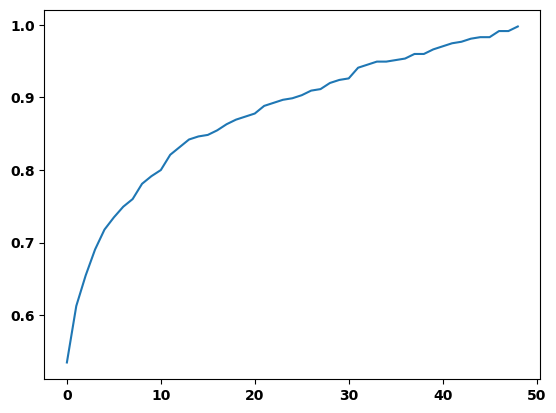

In [185]:
plt.plot(cmc)
print(r1,r2)

0.5052631578947369 0.7031578947368421


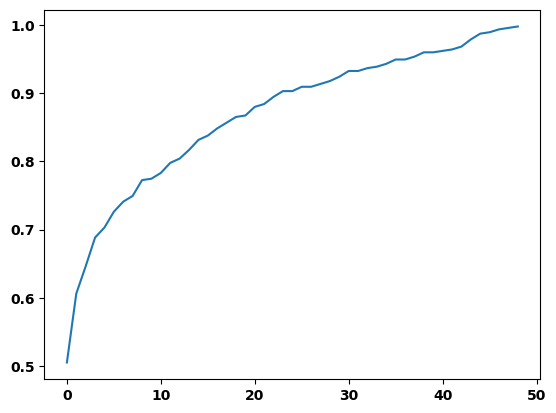

In [183]:
plt.plot(cmc)
print(r1,r2)

In [ ]:
len(df_tes)

412